# Group Convolutional Networks

**Author:** Aron Jansen (work in progress)

This notebook goes through the framework of group convolutional networks, which in addition to being invariant (or equivariant) to translations as vanilla CNNs are, are also invariant (equivariant) to a discrete symmetry group.

This notebook is based on [the original paper](http://proceedings.mlr.press/v48/cohenc16.html) by Taco Cohen and Max Welling, and also heavily based on the book, lectures and notebooks on the geommetric deep learning by Micheal Bronstein, Joan Bruna, Taco Cohen and Petar Veličković, found [here](https://geometricdeeplearning.com). 
All credit goes to them, and all mistakes  are my own.

If you've somehow stumbled upon this I recommend first of all to wait for me to come back from vacation and clean this up. I plan to both improve on the explanation (the current was written as I was going through it myself), implement several different groups and show them as examples, and hopefully speed up the implementation (currently training a small group-CNN is about 6 times slower than a similar size vanilla CNN).

Also, currently while the GroupConv2D layer is equivariant (both for lifting and group convolutions), a whole network that includes pooling still is not, not sure why.

Other than that I recommend first watching the geometric deep learning lectures mentioned above, at least up to lecture 8, and then perhaps to go through the first tutorial there in parallel with this notebook. The explanation here is more detailed in some places and less in others, and using Keras rather than Pytorch.

## The group p4m

Before going to group-CNNs, we first explore one particular group as an example: the group of translations, rotations and mirroring of the plane.

A group element takes the form $({\bf t}, r, f)$, which acts on the plane as:
1. $f \in \{0, 1\}$ (True or False) flips along the horizontal direction, $f(x, y) = (-x, y)$
2. $r \in \{0, 1, 2, 3\}$ rotates by $r \frac{\pi}{2}$, counterclockwise around the origin
3. ${\bf t} = (t_x, t_y)$ translates

A generic element takes all three actions in the order given.

Consider the pure flips, rotations and translations, and the identity $e$:
- $F = (0, 0, 1)$,   
    - $F\cdot(x, y) = (-x, y)$
- $R = (0, 1, 0)$
    - $R\cdot(x, y) = (-y, x)$
- ${\bf t} = ({\bf t}, 0, 0)$
    - ${\bf t}\cdot(x, y) = (x + t_x, y + t_y)$
- $e = (0, 0, 0)$
    -  $e \cdot (x, y) = (x, y)$

(Where for later clarity we write the action of a group element $g$ on a point $(x, y)$ as $g \cdot (x, y)$.)

Then we can write any element as:
$({\bf t}, r, f) = {\bf t} \odot R^r \odot F^f$, where $\odot$ denotes group composition.

Each component creates its own subgroup:
- $F \odot F = e$, flips are a 2 dimensional subgroup
- $R^r \odot R^s = R^{r + s \mod 4}$, rotations give the 4-dimensional cyclic group
- ${\bf t} \odot {\bf r} = \bf{t + r}$, translations trivially form the group of translations

Now to find the group composition, we need to untangle the following expression,
$a \odot b = {\bf t}_a \odot R^{r_a} \odot F^{f_a} \odot {\bf t}_b \odot R^{r_b} \odot F^{f_b} = {\bf t}_c \odot R^{r_c} \odot F^{f_c} = c$.

So we want to pull first the $F^{f_a}$ past the ${\bf t}_b \odot R^{r_b}$ to find $f_c$, and then pull $R^{r_b}$ past ${\bf t}_b$ to find $r_c$, which will then also allow us to find ${\bf t}_c$.
These do not commute, but by looking at the action on the plane we can see how we can still swap elements:

- $\begin{align}
(F \odot {\bf t})\cdot(x, y) &= F\cdot(x + t_x, y + t_y) = (-x - t_x, y + t_y)\\
&= (F\cdot{\bf t})\cdot(-x, y) = ((F\cdot{\bf t}) \odot F)\cdot(x, y)
\end{align}$
- $\begin{align}
(F \odot R)\cdot(x, y) &= F\cdot(-y, x) = (y, x) \\
&= R^{-1}\cdot(-x, y) = (R^{-1}\odot F)\cdot(x, y)
\end{align}$
- $\begin{align}
(R \odot {\bf t})\cdot(x, y) &= R\cdot(x + t_x, y + t_y) = (- y - t_y, x + t_x)\\ &= (R\cdot{\bf t})\cdot (-y, x) = ((R\cdot {\bf t}) \odot R)\cdot(x, y)
\end{align}$

where in the first line we let $F$ and $R$ act on ${\bf t}$ as a point in the plane.

Since these three identities hold for all points $(x, y)$, they imply:
- $F \odot {\bf t} = (F{\bf t}) \odot F$
- $F \odot R = R^{-1} \odot F$
- $R \odot {\bf t} = (R{\bf t}) \odot R$

Using these identities and the procedure indicated above we can work out the general group composition to be:
- $f_c = f_a + f_b$
- $r_c = r_a + (1 - 2 f_a) r_b$
- ${\bf t}_c = {\bf t}_a + R^{r_a} F^{f_a} {\bf t}_b$

And from this we can find the inverse element:
- $f^{-1} = f$
- $r^{-1} = - (1 - 2 f) r$
- ${\bf t}^{-1} = - F^f R^{-r} {\bf t}$

The class below implements this group. It uses multiplication as group composition, and `~` can be used as the inverse.

In [1]:
class P4M:
  """
  First flip horizontally, then rotate counterclockwise around origin, then translate.
  """
  def __init__(self, rotation: int=0, flip: int=0, translation: tuple=(0, 0)):
    assert type(translation) == tuple
    self.rotation = rotation % 4
    self.flip = flip % 2
    self.translation = translation
  
  def __mul__(a, b):
    """Compute the group composition a o b."""
    flip = (a.flip + b.flip) % 2
    rotation = (a.rotation + (1 - 2 * a.flip) * b.rotation) % 4
    a_x, a_y = a.translation
    b_x, b_y = b.translation
    if a.flip:
      b_x = -b_x
    for _ in range(a.rotation):
      b_x, b_y = P4M.rotate(b_x, b_y)
    translation = (a_x + b_x, a_y + b_y)

    return P4M(rotation=rotation, flip=flip, translation=translation)

  def __invert__(self):
    flip_inv = self.flip
    rotation_inv = (-(1 - 2 * self.flip) * self.rotation) % 4
    x_inv, y_inv = self.translation
    for _ in range(self.rotation):
      x_inv, y_inv = P4M.inv_rotate(x_inv, y_inv)
    if self.flip:
      x_inv = -x_inv

    translation_inv = x_inv, y_inv
    return P4M(rotation=rotation_inv, flip=flip_inv, translation=translation_inv)

  def __call__(self, point):
    result_x, result_y = point
    if self.flip:
      result_x = -result_x
    for _ in range(self.rotation):
      result_x, result_y = P4M.rotate(result_x, result_y)
    t_x, t_y = self.translation
    return result_x + t_x, result_y + t_y

  def __repr__(self):
    return f'({self.translation}, {self.rotation}, {self.flip})'

  def __str__(self):
    if self.is_identity():
      return 'e'
    string = ''
    if self.translation != (0, 0):
      string += f'{self.translation}'
    if self.rotation > 0:
      string += f'R^{self.rotation}'
    if self.flip:
      string += 'F'

    return string

  def is_identity(self):
    return self.flip == 0 and self.rotation == 0 and self.translation == (0, 0)

  def __eq__(self, other):
    return self.flip == other.flip and self.rotation == other.rotation and self.translation == other.translation
  
  @staticmethod
  def rotate(x, y):
    return -y, x

  @staticmethod
  def inv_rotate(x, y):
    return y, -x

  def __hash__(self):
    return hash((self.flip, self.rotation, self.translation))

## Check the identities

Now we can check the identities we used to derive the group composition. We define `F` and `R` as above to be the flip and single rotation.

The translation is a bit more involved for two reasons. First, we didn't have a single representative of this subgroup. It can of course be built from two generators (the unit translation in the x direction and the unit translation in the y direction), but this only complicates things, so we just pick a generic point.

The more interesting complication is that we can identify a pure translation in the group with a point on the plane, on which the group acts. It makes the code a bit more cumbersome than for the identity that doesn't involve a translation, but that is good in that it stresses that these are two different objects. In most cases such a mapping cannot be done.

In [2]:
F = P4M(flip=1)
R = P4M(rotation=1)
T_point = (4, 2)
T = P4M(translation=T_point)

print(F * T == P4M(translation=F(T_point)) * F)
print(F * R == ~R * F)
print(R * T == P4M(translation=R(T_point)) * R)

True
True
True


## Checking the full multiplication table

In [3]:
unique_elements = []
for flip in range(2):
  for rotation in range(4):
    unique_elements.append(P4M(flip=flip, rotation=rotation))

products = [[a * b for b in unique_elements] for a in unique_elements]

In [4]:
from tabulate import tabulate

print("Group composition: row o column")
print(tabulate(products, headers=unique_elements, showindex=unique_elements, tablefmt='fancy_grid'))

Group composition: row o column
╒══════╤══════╤═══════╤═══════╤═══════╤══════╤════════╤════════╤════════╕
│      │ e    │ R^1   │ R^2   │ R^3   │ F    │ R^1F   │ R^2F   │ R^3F   │
╞══════╪══════╪═══════╪═══════╪═══════╪══════╪════════╪════════╪════════╡
│ e    │ e    │ R^1   │ R^2   │ R^3   │ F    │ R^1F   │ R^2F   │ R^3F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^1  │ R^1  │ R^2   │ R^3   │ e     │ R^1F │ R^2F   │ R^3F   │ F      │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^2  │ R^2  │ R^3   │ e     │ R^1   │ R^2F │ R^3F   │ F      │ R^1F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^3  │ R^3  │ e     │ R^1   │ R^2   │ R^3F │ F      │ R^1F   │ R^2F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ F    │ F    │ R^3F  │ R^2F  │ R^1F  │ e    │ R^3    │ R^2    │ R^1    │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^1F

## Group action on signals

### Group Representations

So far we have interpreted the group as acting on the plane. We have also in a way looked at the action of the group on itself: this is just another way of looking at the group composition rules we derived.

Formally an action of a group that sends points in a set to other points in the same set is called a representation of that group. An important constraint on a representation is that its action is compatible with the group composition.
That is, if we act with group element b on a point x, and then act with element a on the result, we should obtain the same result when acting with the group element $(a \odot b)$ directly on x:
$a(b(x)) = (a \odot b)(x)$.

In fact in the above we implicitly assumed this to hold and used it to derive the group composition.


$\Omega = \mathbb{R}^2$

### Signals

We are not interested in the plane itself though, but rather in _signals_ on the plane: functions $\mathcal{X}(\Omega, \mathcal{C}) = \{f: \Omega \rightarrow \mathcal{C}\}$. For instance if we are interested in color images, in this language an image would be a function $f \in \mathcal{X}(\mathbb{Z}^h \times \mathbb{Z}^w, \mathbb{R}^3)$. The actual data encoding the image itself consists of this function evaluated on all points in its domain: a 3-tensor of shape (h, w, 3) whose entry i, j gives the RGB values of the pixel in the ith row and jth column of the image.

From a group G acting on a domain $\Omega$, we can immediately construct an action, a group representation, of the group on signals $\mathcal{X}(\Omega, \mathcal{C})$ on this domain: for $g \in G$, $y \in \mathcal{X}$ and $x \in \Omega$:

$(gy)(x) = y(g^{-1}(x))$.

The inverse here is crucial to make this a proper group representation. This can be seen by looking at another group element $h \in G$ and verifying that this makes the action compatible with group composition:
$(hgy)(x) = (h(gy))(x) = (gy)(h^{-1}x) = y(g^{-1}h^{-1}x) = y((hg)^{-1} x) = ((hg)y)(x)$.

This shows that the way we put the brackets doesn't matter: $h(gy) = (hg)y$, which means that this action is indeed a representation of the group on signals on the domain. In the above we used that $(hg)^{-1} = g^{-1}h^{-1}$.

We have just created a representation of the group on signals on the domain $\Omega$ purely through the group action directly on $\Omega$ that we already had. But we also already had another group action: the one on the group itself by composition. Using this we can repeat the trick to create a group action on signals on the group itself

$\cdot, \odot, \star, \times$




## Group Actions
To summarize, these are the relevant group actions.

\begin{array}{c|cccc}
\text{space}&\text{action}&\text{computed as} & \text{meaning} & \text{shape}\\
\hline
\Omega& g \cdot p & - & \text{pixel indices} & (h, w)\\
G & g \odot h & - & \text{transformations} & (n_g, h, w)\\
\mathcal{X}(\Omega) & (g \otimes x)(p) & x(g^{-1}\cdot p) & \text{image} & ( h, w, n_c)\\
\mathcal{X}(G) & (g \times y)(h) & y(g^{-1} \odot h) & \text{hidden activations} & (n_g, h, w, n_c)
\end{array}

In the two signal spaces, note that the group action does not depend on the image of the signals, only their domain. That is why the image is not indicated, although in both cases it will turn out to be the group itself.

We have reduced the 4 actions effectively to two: the action on the domain and the composition of group elements.
As the group in question is a combination of translations and a discrete group, we can decompose this further. In fact, the group composition acts on the translational part exactly as it does on the domain itself. We can easily check this with an example:

In [5]:
g = T * F * R
print('g: ', g)

h = P4M(translation=(3, 1)) * F
print('h: ', h)
x = (3, 1)
print('x: ', x)
print('gx: ', g(x))
print('gh: ', g * h)

g:  (4, 2)R^3F
h:  (3, 1)F
x:  (3, 1)
gx:  (5, 5)
gh:  (5, 5)R^3


So the action on the group can be decomposed as first acting on the translation group element as if it was in the domain itself, and then acting on the discrete group elements. The discrete part by definition is nothing but a permutation, and for a given group element the corresponding permutation is precisely the one indicated in the multiplication table above.

So to act with a particular group element $g$ on a signal $\mathcal{X}(G)$ of shape $(n_h, n_g, h, w)$:

1. Apply the flip and rotation on the $(h, w)$ dimensions
2. Apply the translation on the $(h, w)$ dimensions
3. Permute the $n_g$ dimension according to the row of $g$ in the multiplication table.

And acting on signals on the domain $\mathcal{X}(\Omega)$ is the same, simply omit the last step.

Generalizing this to any group that combines translations with a discrete group, the two pieces of information we need for every discrete group element are these:
1. A permutation giving the discrete part of the group composition
2. an action on $\Omega$

The translations are of course already implemented in vanilla CNNs. We will modfiy Keras's Conv2D layer to add the two pieces of information above.

### Group composition

As mentioned we can get the permutations corresponding to group composition directly from the table we created above:

In [6]:
elem_numbers = {g: i for i, g in enumerate(unique_elements)}
permutations = [[elem_numbers[g] for g in row] for row in products]
permutations

[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 0, 5, 6, 7, 4],
 [2, 3, 0, 1, 6, 7, 4, 5],
 [3, 0, 1, 2, 7, 4, 5, 6],
 [4, 7, 6, 5, 0, 3, 2, 1],
 [5, 4, 7, 6, 1, 0, 3, 2],
 [6, 5, 4, 7, 2, 1, 0, 3],
 [7, 6, 5, 4, 3, 2, 1, 0]]

### Action on $\Omega$


For the actions, we had previously defined the action on a plane as acting on a single point, in $\mathbb{R}^2$, or possibly a single point in $\mathbb{Z}^h \times \mathbb{Z}^w$ as desired.

But we want the action on the whole plane, and we want rotations and reflections to be with respect to the middle pixel, not the origin.

There are most likely efficient implementations of these transformations.
So if we change out the group, the permutations are very simple to obtain, but what might require some work is an efficient implementation of the transformations.

In this case, a flip is a reversal of the indices and a rotation can be done as a combination of a flip and a transposition. With the elementary transformations:
1. horizontal flip
2. vertical flip
3. transposition

we can create 2^3 = 8 different transformations, matching the group order.

In [7]:
from tensorflow import keras
import tensorflow as tf

h_tmp = 3
w_tmp = 3
c_tmp = 1


x = tf.random.normal(shape=(h_tmp, w_tmp, c_tmp))
print(x)

tf.Tensor(
[[[ 0.39778996]
  [ 0.35619769]
  [ 0.84377354]]

 [[ 0.95732456]
  [ 0.00819023]
  [ 0.4512188 ]]

 [[-0.67850506]
  [-0.47851357]
  [-0.9308967 ]]], shape=(3, 3, 1), dtype=float32)


In [8]:
def tf_flip(x, height_axis=-3, width_axis=-2):
  return tf.reverse(x, axis=[width_axis])

def tf_rotate(x, height_axis=-3, width_axis=-2):
  axes = list(range(len(x.shape)))
  axes[height_axis], axes[width_axis] = axes[width_axis], axes[height_axis]
  return tf.reverse(tf.transpose(x, perm=axes), axis=[height_axis])

def tf_action(x, rotation, flip, height_axis=-3, width_axis=-2):
  if flip:
    x = tf_flip(x, height_axis=height_axis, width_axis=width_axis)
  for _ in range(rotation):
    x = tf_rotate(x, height_axis=height_axis, width_axis=width_axis)
  return x

In [9]:
import numpy as np
print(x[:,:,0])
print(tf_action(x, rotation=1, flip=0)[:,:,0])
print(tf_action(x, rotation=0, flip=1)[:,:,0])

tf.Tensor(
[[ 0.39778996  0.35619769  0.84377354]
 [ 0.95732456  0.00819023  0.4512188 ]
 [-0.67850506 -0.47851357 -0.9308967 ]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 0.84377354  0.4512188  -0.9308967 ]
 [ 0.35619769  0.00819023 -0.47851357]
 [ 0.39778996  0.95732456 -0.67850506]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 0.84377354  0.35619769  0.39778996]
 [ 0.4512188   0.00819023  0.95732456]
 [-0.9308967  -0.47851357 -0.67850506]], shape=(3, 3), dtype=float32)


# Geometric DL Blueprint

Equivariant layers
Final invariant layer

So need to find equivariant and invariant functions with respect to the whole group of translations and discrete transformations.

Convolutions are equivariant transformations with respect to shift symmetry.



## Equivariant Layer: Group convolution

For a given group $G$, a filter $\psi \in \mathcal{X}(\Omega, \mathcal{C})$ and a signal $x \in \mathcal{X}(\Omega, \mathcal{C})$, a _group convolution_ is a map:
$F_\psi^G: \mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(G, \mathcal{C})$ defined as:

$F_\psi^G(x)(g) \equiv (\psi \star x)(g) = \sum_{p\in\Omega} \langle(g \otimes \psi)(p), x(p)\rangle_\mathcal{C}$.

To see that this is $G-$equivariant, transform either the output or the input with $h \in G$ and use the previously defined regular representations:
- $(h \otimes F_\psi^G(x))(g) = F_\psi^G(x)(h^{-1} \odot g) = \sum_{p\in\Omega} \langle [(h^{-1} \odot g) \otimes \psi](p), x(p) \rangle_\mathcal{C}$
- $F_\psi^G(h \otimes x)(g) = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

So if we can show that for all $p \in \Omega$,

$\sum_{p\in\Omega}\langle [(h^{-1} \odot g) \otimes \psi](p), x(p) \rangle_\mathcal{C} = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

then $F_\psi^G$ is $G-$equivariant. 
We can make the left hand side look more like the right hand side by rewriting it as:
- $[(h^{-1} \odot g) \otimes \psi](p) = [h^{-1} \otimes (g \otimes \psi)](p) = (g \otimes \psi)(h \cdot p)$
- $x(p) = (h \otimes x)(h \cdot p)$

Making heavy use of the fact that $G$ acts on $\psi$ and $x$ as the regular representation.
After these transformations, the only difference between the left and right hand sides is the argument: $p$ on the right and $h \cdot p$ on the left.
So without the sum, the two sides are _not_ equal, but as long as both sides still sum over the same set, they are equal. So what we need is that $h \cdot \Omega = \Omega$, for any $h \in G$. 

This is true and follows from the exitance of the inverse $h^{-1} \in G$: if $h\cdot p = h\cdot q$, then by applying $h^{-1}$ to both sides we get $p = q$, 
so $h$ maps different elements to different elements, and so maps $\Omega$ to all of $\Omega$, as desired.

So far we have considered signals on $\Omega$, but a group convolution can be defined in the same way for signals on the group itself. The arguments are now in the group $G$ instead of in the domain $\Omega$, and so the sums are over the group as well. The proof of equivariance goes through in the same way, as also $h\odot G = G$, since for all $g$, $h^{-1} \odot g \in G$ and so $g \in h \odot G$.

Note that noewhere in this discussion we have used that the group contains translations, this is not necessary in order to define a group convolution. On the other hand, if the group consists of pure translations this definition simplifies to the usual convolution. If $\Omega$ is a one-dimensional grid and $G$ pure translations, and the signals are just real numbers ($\mathcal{C} = \mathbb{R}$),  the first line of this section results in:

$(\psi \star x)(g) = \sum_p \psi(p - g) x(p)$

### Practical implementation

To implement the group convolution, we need to transform each filter with every group element. For the subgroup of translations this is already taken care of in the standard convolution layer of all deep learning frameworks.

We have already implemented the discrete part above, we just need to apply that to the filters. (and so not to the image or hidden activations)

We will want to apply all (discrete) group transformations at once though, and concatenate the result.

Also when acting on a signal on the group, as will be the case in all but the first convolutional layer, we need to permute the group index.
We also need to sum over this index in this case, but only after multiplication with the signal.

In [10]:
# default keras ordering of image axes:
# (b, h, w, c) 
# make signals on group have shape
# (b, g, h, w, c)

In [11]:
from tensorflow.keras.layers import Conv2D, Input
from keras.engine.input_spec import InputSpec

# the group action, how to implement?
# right now it needs to know about the index the group should go on
# might be cleaner not to, instead give one transformation per group element?
# but that'd be slower?

class GroupConv2D(Conv2D):
  """
  Group convolution layer built on Keras's Conv2D layer.
  Additional arguments:
  - group_composition: specifies the group composition, r composed with c gives group_composition[r, c]
  - group_action: A function that takes in a kernel of shape (height, width, channels_in, channels_out),
                  and outputs a kernel of shape (group_order, height, width, channels_in, channels_out),
                  consisting of the original filter transformed by all group elements, and stacked along the group_order axis. 


  NOTE: the option data_format='channels_first' is not supported.

  If the input is a signal on the grid, it is of shape (height, width, in_channels), and the kernel has the same axes plus an extra out_channels axis.
  If the input is a signal on the group, it is of shape (group_order, height, width, channels), and so, conceptually, is the filter
  but to treat it as a built in convolution we need to reshape the input to (height, width, group_order * in_channels).
  This will automatically make the kernel take group_order * in_channels as its own in_channels dimension.
  """
  def __init__(self, group_action, group_composition: tf.Tensor, **kwargs):
    self.group_order = group_composition.shape[0]
    self.group_action = group_action
    self.group_composition = group_composition
    self.group_valued_input = None # set during build

    super().__init__(**kwargs)

  def call(self, inputs):
    outputs = self.original_call(
        self.reshape_inputs(inputs),
        self.group_transform(self.kernel),
        self.repeat_bias()
        )
    outputs = self.restore_group_index(outputs)
    return outputs

  def build(self, input_shape):
    """
    Checks if the input is a signal on the group (rather than just on the grid) and stores that in attribute group_valued_input.
    If so, the group axis is merged with the channel axis.
    Then runs the parent class's build.
    """
    self.group_valued_input = len(input_shape) == 5 # this includes the batch dimension
    if self.group_valued_input:
      (batch, group_order, height, width, channels) = input_shape
      assert group_order == self.group_order, f'got shape {input_shape}, expected {(batch, self.group_order, height, width, channels)}.'
      input_shape = (batch, height, width, channels * group_order)

    super().build(input_shape)

    if self.group_valued_input:
      self.input_spec.axes = {self._get_channel_axis(): channels}

  def reshape_inputs(self, inputs):
    """If the input is a signal on the group, join the group axis with the channel axis."""
    if not self.group_valued_input:
      return inputs

    batch, group_order, height, width, channels = inputs.shape
    batch = -1 if batch is None else batch
    assert group_order == self.group_order
    reshaped_inputs = tf.transpose(inputs, [0, 2, 3, 4, 1])
    reshaped_inputs = tf.reshape(inputs, (batch, height, width, group_order * channels))
    return reshaped_inputs

  def group_transform(self, kernel):
    transformed_kernel = self.group_action(kernel)
    if self.group_valued_input:
      transformed_kernel = self.discrete_group_transform(transformed_kernel)

    transformed_kernel = self.merge_group_channels_out(transformed_kernel)
    return transformed_kernel

  def discrete_group_transform(self, kernel):
    """
    Takes in the kernel of shape (group_order, height, width, channels_in, channels_out),
    where the first axis is the group element that was used to transform that component,
    and channels_in is actually channels_in * group_order, containing also the group argument.
    Splits out the group argument axis, permutes those according to the group action, and brings it back to the original shape.
    """
    (group_order, height, width, channels_in, channels_out) = kernel.shape
    assert channels_in % self.group_order == 0, f'Number of input channels {channels_in} not divisible by group order {self.group_order}!'
    transformed_kernel = tf.reshape(kernel, (group_order, height, width, channels_in // self.group_order, self.group_order, channels_out))

    permuted_group_indices = [tf.gather(transformed_kernel[i], axis=-2, indices=self.group_composition[i]) # if the group composition is correct like this, should have transposed it before input?
                              for i in range(self.group_order)]
    transformed_kernel = tf.concat(permuted_group_indices, axis=0)
    transformed_kernel = tf.reshape(transformed_kernel, (group_order, height, width, channels_in, channels_out))
    return transformed_kernel

  def merge_group_channels_out(self, kernel):
    """Reshapes kernel of shape (group_order, height, width, channels_in, channels_out)
    to (height, width, channels_in, channels_out * group_order)."""
    transformed_kernel = tf.transpose(kernel, [1, 2, 3, 4, 0])
    height, width, channels_in, channels_out, group_order = transformed_kernel.shape
    transformed_kernel = tf.reshape(transformed_kernel, (height, width, channels_in, channels_out * self.group_order))
    return transformed_kernel

  def repeat_bias(self):
    """Transforms the bias to group_order repeated copies of itself."""
    return tf.repeat(self.bias, self.group_order, axis=0) if self.use_bias else None

  def restore_group_index(self, outputs):
    """
    Reshapes the output of the convolution, splitting off the group index from the channel axis.
    Input shape: (batch, height, width, group_order * channels)
    Output shape: (batch, group_order, height, width, channels)
    """
    batch, height, width, channels = outputs.shape
    assert channels % self.group_order == 0, f'number of channels {channels} not divisible by group order {self.group_order}.'
    batch = -1 if batch is None else batch
    reshaped_outputs = tf.reshape(outputs, (batch, height, width, channels // self.group_order, self.group_order))
    reshaped_outputs = tf.transpose(reshaped_outputs, [0, 4, 1, 2, 3])
    return reshaped_outputs
  
  def original_call(self, reshaped_inputs, reshaped_kernel, reshaped_bias):
    """
    This is the original call method, with replacements:
    - self.kernel -> reshaped_kernel (argument)
    - self.bias -> reshaped_bias (argument)
    - self.filters -> filters_multiplied (self.filters * self.group_order)
    - out_shape features multiplied by group_order if group_valued_input
    """
    

    if self._is_causal:  # Apply causal padding to inputs for Conv1D.
      reshaped_inputs = tf.pad(reshaped_inputs, self._compute_causal_padding(reshaped_inputs))

    outputs = self._convolution_op(reshaped_inputs, reshaped_kernel) # had to add underscore to make it work

    if self.use_bias:
      filters_multiplied = self.filters * self.group_order
      output_rank = outputs.shape.rank
      if self.rank == 1 and self._channels_first:
        # nn.bias_add does not accept a 1D input tensor.
        bias = tf.reshape(reshaped_bias, (1, filters_multiplied, 1))
        outputs += bias
      else:
        # Handle multiple batch dimensions.
        if output_rank is not None and output_rank > 2 + self.rank:

          def _apply_fn(o):
            return tf.nn.bias_add(o, reshaped_bias, data_format=self._tf_data_format)

          outputs = conv_utils.squeeze_batch_dims(
              outputs, _apply_fn, inner_rank=self.rank + 1)
        else:
          outputs = tf.nn.bias_add(
              outputs, reshaped_bias, data_format=self._tf_data_format)

    if not tf.executing_eagerly():
      # Infer the static output shape:
      input_shape = reshaped_inputs.shape.as_list()
      out_shape = self.compute_output_shape(input_shape)

      batch, height, width, channels = out_shape
      out_shape = batch, height, width, channels * self.group_order
      outputs.set_shape(out_shape)

    if self.activation is not None:
      return self.activation(outputs)
    return outputs

In [12]:
@tf.function
def P4M_action(kernel, new_group_axis=0, height_axis=0, width_axis=1):
  return tf.concat([tf.expand_dims(tf_action(kernel, rotation=g.rotation, flip=g.flip, height_axis=height_axis, width_axis=width_axis), 
                                   axis=new_group_axis) for g in unique_elements], axis=new_group_axis)

P4M_permutation = tf.constant(permutations)

In [13]:
from functools import partial

P4M_Conv2D = partial(GroupConv2D, group_action=P4M_action, group_composition=P4M_permutation)


input_shape = (8, 28, 28, 1)
inputs = Input(shape=input_shape)
outputs = P4M_Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [14]:
from tensorflow.keras.models import Model

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 28, 28, 1)]    0         
_________________________________________________________________
group_conv2d (GroupConv2D)   (None, 8, 26, 26, 32)     2336      
Total params: 2,336
Trainable params: 2,336
Non-trainable params: 0
_________________________________________________________________


## Testing Equivariance

In [15]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

input_shape = (28, 28, 1)
num_classes = 10

11493376/11490434 [==============================] - 0s 0us/step


### On a lifting-convolution

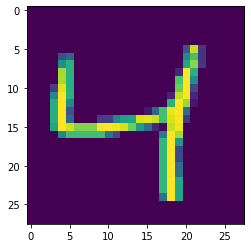

In [16]:
from matplotlib import pyplot as plt
import numpy as np

image = np.reshape(x_train[2].numpy(), (28, 28))
plt.imshow(image)

In [17]:
my_P4M_layer = P4M_Conv2D(filters=3, kernel_size=(5, 5), activation='sigmoid')

Maximal absolute difference between g.conv(x) and conv(g.x): 1.1920928955078125e-07


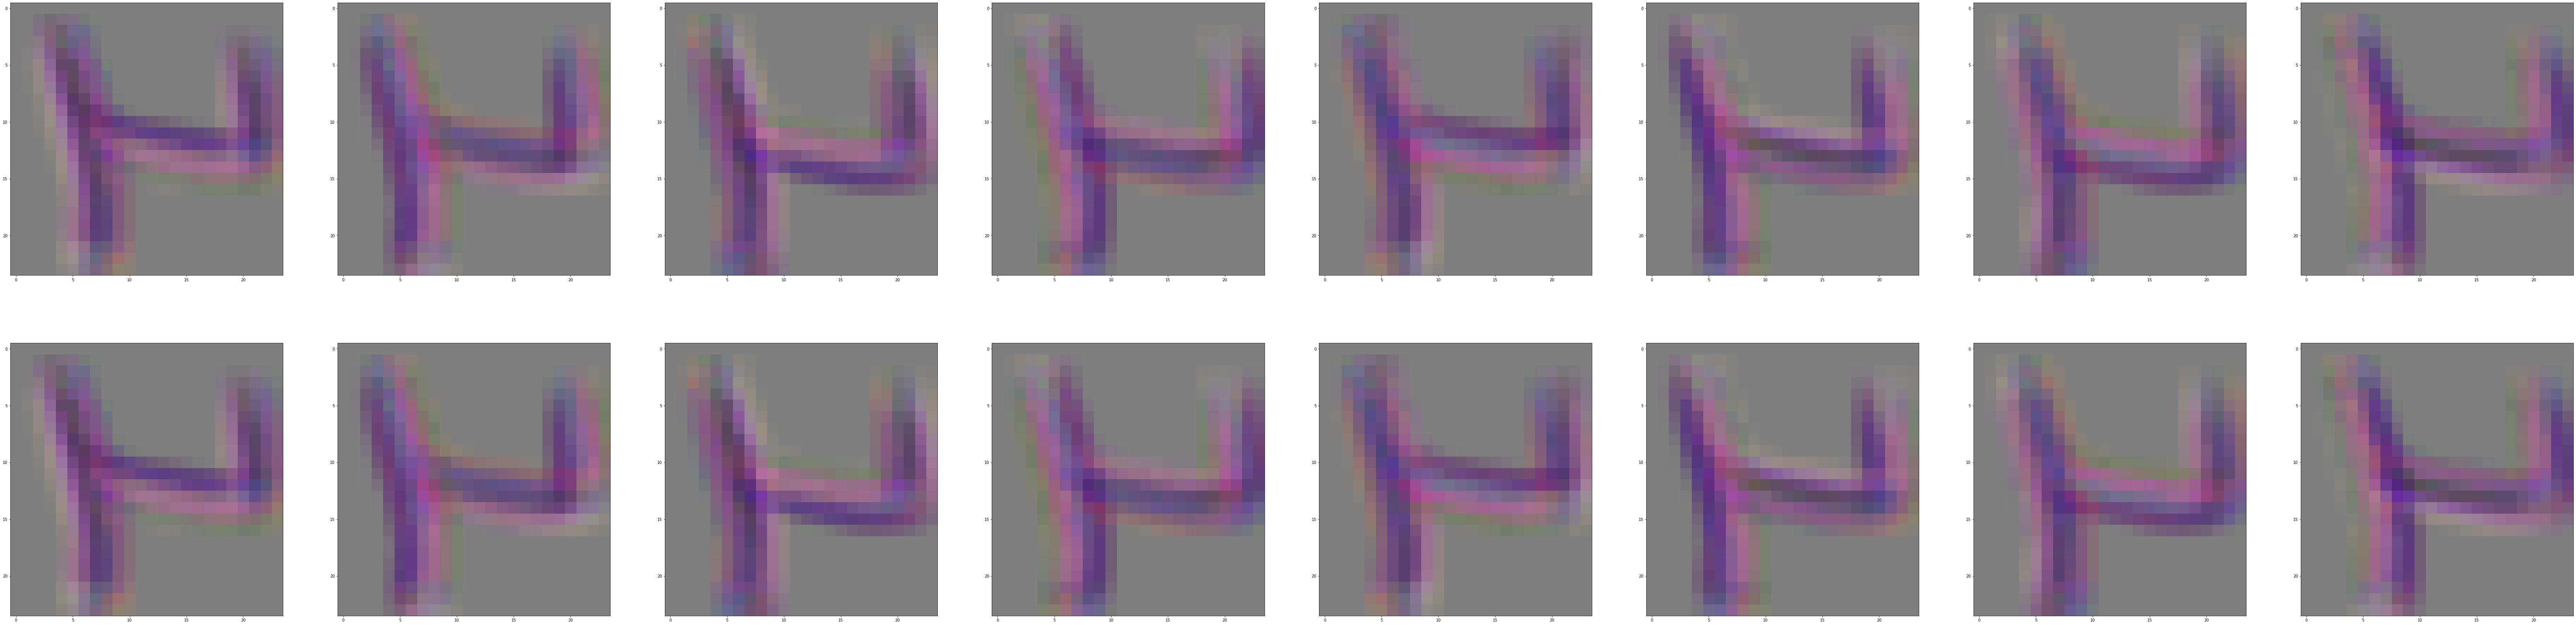

In [18]:
image_reshaped = np.reshape(image, (1, 28, 28, 1))

g_index = 4
x = np.reshape(x_train[2].numpy(), (1, 28, 28, 1))
gx = P4M_action(x, height_axis=1, width_axis=2)[g_index]
conv_x = my_P4M_layer(x)
conv_gx = my_P4M_layer(gx)[0]
g_conv_x = P4M_action(conv_x, height_axis=2, width_axis=3)[g_index][0]
g_conv_x = tf.gather(g_conv_x, axis=0, indices=P4M_permutation[g_index])

fig, axes = plt.subplots(2, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
for i in range(8):
  axes[0, i].imshow(g_conv_x[i])
  axes[1, i].imshow(conv_gx[i])
fig.show()
print(f'Maximal absolute difference between g.conv(x) and conv(g.x): {tf.reduce_max(tf.abs(g_conv_x - conv_gx)).numpy()}')

### On a group-convolution

In [19]:
my_P4M_layer_group_conv = P4M_Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid')

In [20]:
my_P4M_layer_group_conv = P4M_Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')

Maximal absolute difference between g.conv(y) and conv(g.y): 1.1920928955078125e-07


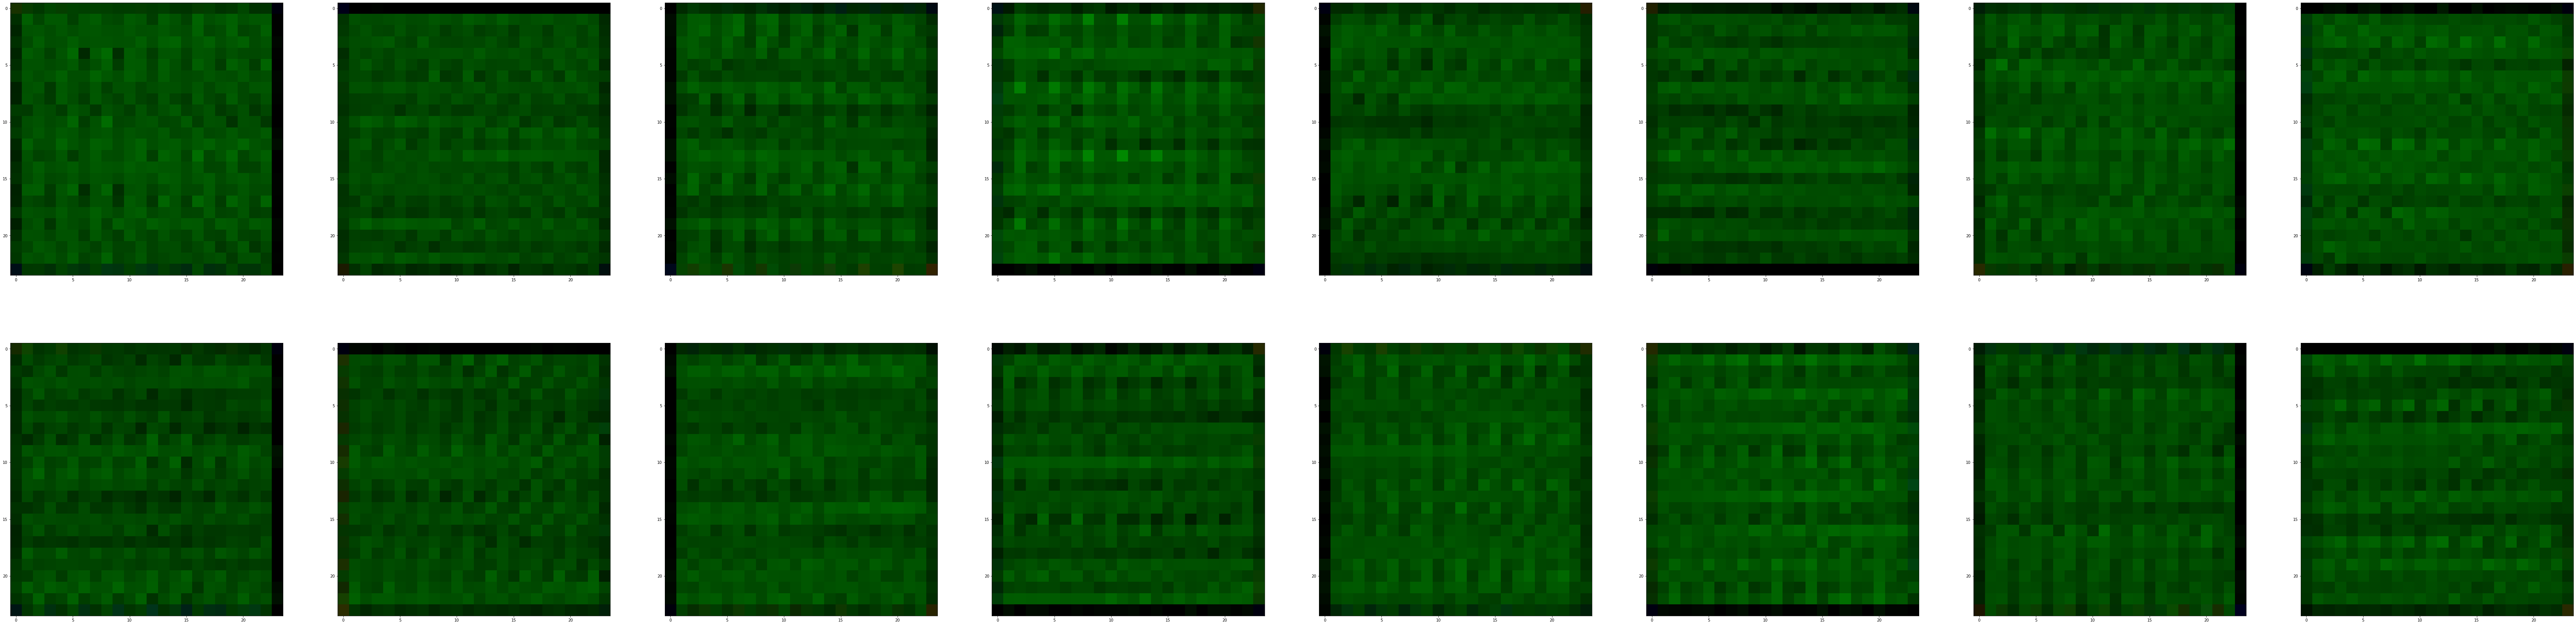

In [21]:
y = conv_x
conv_y = my_P4M_layer_group_conv(y)
def act_on_group_signal(signal, g_index):
  temp = P4M_action(signal, height_axis=2, width_axis=3)[g_index][0]
  temp = tf.gather(temp, axis=0, indices=P4M_permutation[g_index])
  return temp

gy = act_on_group_signal(y, g_index)
g_conv_y = act_on_group_signal(conv_y, g_index)

conv_gy = my_P4M_layer_group_conv(tf.reshape(gy, (1) + gy.shape))[0]


fig, axes = plt.subplots(2, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
for i in range(8):
  axes[0, i].imshow(g_conv_y[i][:, :, :3])
  axes[1, i].imshow(conv_gy[i][:, :, :3])
fig.show()
print(f'Maximal absolute difference between g.conv(y) and conv(g.y): {tf.reduce_max(tf.abs(g_conv_x - conv_gx)).numpy()}')

In [22]:
print(f'Maximal absolute difference between g.conv(y) and conv(g.y): {tf.reduce_max(tf.abs(g_conv_x + conv_gx)).numpy()}')

Maximal absolute difference between g.conv(y) and conv(g.y): 1.4007987976074219


## Invariant layer: pooling

# Testing on MNIST

## Regular CNN on MNIST

In [23]:
from tensorflow import keras
import tensorflow as tf

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, Dense, Dropout, Input, Flatten, GlobalMaxPooling2D, GlobalMaxPooling3D
from tensorflow.keras.models import Model

def create_pooling_layer(my_conv=Conv2D):
  if my_conv is Conv2D:
    return MaxPooling2D(pool_size=(2, 2))
  else:
    return MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')

def construct_model(my_conv=Conv2D, filter_sizes=[32, 64]):
  input_shape = (28, 28, 1)
  if my_conv is Conv2D:
    invariant = GlobalMaxPooling2D()
  else:
    invariant = GlobalMaxPooling3D() 
  inputs = Input(shape=input_shape)
  x = inputs
  for filters in filter_sizes[:-1]:
    x = my_conv(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = create_pooling_layer(my_conv)(x)
  x = my_conv(filters=filter_sizes[-1], kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = invariant(x)
  #x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)
  outputs = x
  return Model(inputs=inputs, outputs=outputs)

In [25]:
regular_cnn = construct_model()
regular_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 19,466
Trainable params: 19,466
Non-trainable params: 0
_______________________________________________________

In [26]:
batch_size = 128
epochs = 15
regular_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
regular_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 6s 9ms/step - loss: 0.8217 - acc: 0.7915 - val_loss: 0.2015 - val_acc: 0.9432
Epoch 2/15
422/422 [==============================] - 3s 8ms/step - loss: 0.1891 - acc: 0.9447 - val_loss: 0.1398 - val_acc: 0.9565
Epoch 3/15
422/422 [==============================] - 3s 8ms/step - loss: 0.1420 - acc: 0.9566 - val_loss: 0.1303 - val_acc: 0.9598
Epoch 4/15
422/422 [==============================] - 3s 8ms/step - loss: 0.1216 - acc: 0.9623 - val_loss: 0.1112 - val_acc: 0.9663
Epoch 5/15
422/422 [==============================] - 3s 8ms/step - loss: 0.1071 - acc: 0.9669 - val_loss: 0.0938 - val_acc: 0.9722
Epoch 6/15
422/422 [==============================] - 4s 8ms/step - loss: 0.0953 - acc: 0.9704 - val_loss: 0.1054 - val_acc: 0.9673
Epoch 7/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0881 - acc: 0.9731 - val_loss: 0.0900 - val_acc: 0.9708
Epoch 8/15
422/422 [==============================] - 3s 8ms/step - loss: 0.

In [27]:
regular_cnn.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 0s 5ms/step - loss: 0.0627 - acc: 0.9788


[0.06268589198589325, 0.9787999987602234]

## Group-CNN on transformed MNIST

In [28]:
group_cnn = construct_model(my_conv=P4M_Conv2D, filter_sizes=[32, 8])
group_cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
group_conv2d_4 (GroupConv2D) (None, 8, 28, 28, 32)     320       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 14, 14, 32)     0         
_________________________________________________________________
group_conv2d_5 (GroupConv2D) (None, 8, 14, 14, 8)      18440     
_________________________________________________________________
global_max_pooling3d (Global (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 18,850
Trainable params: 18,850
Non-trainable params: 0
_______________________________________________________

In [29]:
batch_size = 128
epochs = 15
group_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
group_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 25s 54ms/step - loss: 0.8775 - acc: 0.7341 - val_loss: 0.3064 - val_acc: 0.9147
Epoch 2/15
422/422 [==============================] - 22s 53ms/step - loss: 0.3200 - acc: 0.9090 - val_loss: 0.2181 - val_acc: 0.9410
Epoch 3/15
422/422 [==============================] - 22s 52ms/step - loss: 0.2483 - acc: 0.9303 - val_loss: 0.1857 - val_acc: 0.9488
Epoch 4/15
422/422 [==============================] - 22s 52ms/step - loss: 0.2158 - acc: 0.9377 - val_loss: 0.1703 - val_acc: 0.9517
Epoch 5/15
422/422 [==============================] - 22s 52ms/step - loss: 0.1902 - acc: 0.9443 - val_loss: 0.1605 - val_acc: 0.9573
Epoch 6/15
422/422 [==============================] - 22s 52ms/step - loss: 0.1755 - acc: 0.9475 - val_loss: 0.1508 - val_acc: 0.9563
Epoch 7/15
422/422 [==============================] - 22s 52ms/step - loss: 0.1623 - acc: 0.9519 - val_loss: 0.1460 - val_acc: 0.9592
Epoch 8/15
422/422 [==============================] - 22s 52ms

In [30]:
group_cnn.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 2s 23ms/step - loss: 0.1356 - acc: 0.9591


[0.13555575907230377, 0.9591000080108643]

## Testing invariance

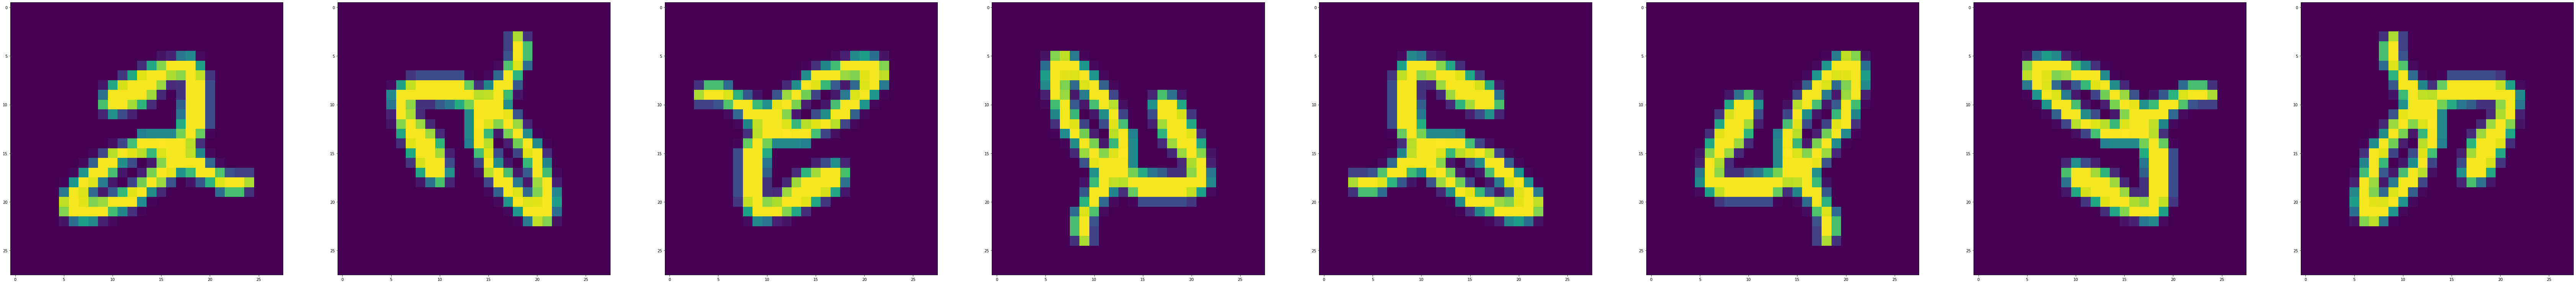

In [31]:
from matplotlib import pyplot as plt
import numpy as np

image = np.reshape(x_train[5].numpy(), (28, 28))

image_2 = np.reshape(image, (1, 28, 28, 1))
transformed_images = P4M_action(image_2, height_axis=1, width_axis=2)
transformed_images = np.reshape(transformed_images, (8, 28, 28))

fig, axes = plt.subplots(1, 8)
fig.set_figheight(15)
fig.set_figwidth(8 * 15)
for i in range(8):
  axes[i].imshow(transformed_images[i])
fig.show()

In [81]:
def act_on_group_signal(signal, g_index):
  print(signal.shape)
  temp = P4M_action(signal, height_axis=2, width_axis=3, new_group_axis=0)[g_index]
  print(temp.shape)
  temp = tf.gather(temp, axis=1, indices=P4M_permutation[g_index])
  print(temp.shape)

  return temp

In [86]:
test_image = np.reshape(transformed_images[0], (1, 28, 28, 1))
g_index = 5
def check_equiv_layer(i, test_image=test_image, g_index=g_index):
  input_model = Model(inputs=group_cnn.inputs, outputs=group_cnn.layers[i - 1].output)
  layer = group_cnn.layers[i]
  print(layer.name)
  input = input_model(test_image)
  print(input.shape)
  layer_input = layer(input)
  print(layer_input.shape)
  if input.shape.rank == 5:
    g_input = act_on_group_signal(input, g_index)
  else:
    g_input = P4M_action(input, height_axis=1, width_axis=2)[g_index]
  print(g_input.shape)
  print(layer.input)
  layer_g_input = layer(g_input)
  print(layer_g_input.shape)
  g_layer_input = act_on_group_signal(layer_input, g_index)

  print(input.shape)
  
  return tf.reduce_max(tf.abs(g_layer_input - layer_g_input))

In [84]:
test_image = np.reshape(transformed_images[0], (1, 28, 28, 1))
g_index = 4
def check_equiv_layer(i, test_image=test_image, g_index=g_index):
  layer_model = Model(inputs=group_cnn.inputs, outputs=group_cnn.layers[i].output)
  print(group_cnn.layers[i].name)
  input = np.reshape(transformed_images[0], (1, 28, 28, 1))
  g_input = np.reshape(transformed_images[g_index], (1, 28, 28, 1))
  layer_input = layer_model(input)
  layer_g_input = layer_model(g_input)
  g_layer_input = act_on_group_signal(layer_input, g_index)
  
  return tf.reduce_max(tf.abs(g_layer_input - layer_g_input))
  #return layer_g_input, g_layer_input

In [87]:
for i in range(1, len(group_cnn.layers) - 2):
  error = check_equiv_layer(i).numpy()
  print(f'Layer {i}: {group_cnn.layers[i].name}, error: {error:.8f}')

group_conv2d_4
(1, 28, 28, 1)
(1, 8, 28, 28, 32)
(1, 28, 28, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
(1, 8, 28, 28, 32)
(1, 8, 28, 28, 32)
(1, 8, 28, 28, 32)
(1, 8, 28, 28, 32)
(1, 28, 28, 1)
Layer 1: group_conv2d_4, error: 0.00000024
max_pooling3d
(1, 8, 28, 28, 32)
(1, 8, 14, 14, 32)
(1, 8, 28, 28, 32)
(1, 8, 28, 28, 32)
(1, 8, 28, 28, 32)
(1, 8, 28, 28, 32)
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 28, 28, 32), dtype=tf.float32, name=None), name='group_conv2d_4/transpose_1:0', description="created by layer 'group_conv2d_4'")
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 32)
(1, 8, 28, 28, 32)
Layer 2: max_pooling3d, error: 0.00000000
group_conv2d_5
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 8)
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 32)
(1, 8, 14, 14, 32)
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 14, 14, 32), dtype=tf.float32, 

In [ ]:
im = np.reshape(transformed_images[0], (1, 28, 28, 1))
g_index = 4
for g_index in range(8):
  g_im = np.reshape(transformed_images[g_index], (1, 28, 28, 1))
  cnn_im = group_cnn(im)
  cnn_g_im = group_cnn(g_im)

  error = tf.reduce_max(tf.abs(cnn_im - cnn_g_im)).numpy()
  print(f'max|G-CNN(x) - G-CNN(g[i].x)| for i = {g_index}: {error:.4f}.')

In [ ]:
help(act_on_group_signal)

In [ ]:
import inspect

In [ ]:
print(inspect.getsource(act_on_group_signal))

In [97]:
pure_conv = keras.models.Sequential([
      keras.layers.InputLayer(input_shape=input_shape),
      P4M_Conv2D(filters=20, kernel_size=3, activation='relu'),
      P4M_Conv2D(filters=20, kernel_size=3, activation='relu'),
      P4M_Conv2D(filters=20, kernel_size=3, activation='relu'),
      GlobalMaxPooling3D(),
      Dense(10)
])
pure_conv.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
group_conv2d_21 (GroupConv2D (None, 8, 26, 26, 20)     200       
_________________________________________________________________
group_conv2d_22 (GroupConv2D (None, 8, 24, 24, 20)     28820     
_________________________________________________________________
group_conv2d_23 (GroupConv2D (None, 8, 22, 22, 20)     28820     
_________________________________________________________________
global_max_pooling3d_6 (Glob (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
Total params: 58,050
Trainable params: 58,050
Non-trainable params: 0
_________________________________________________________________


In [98]:
im = np.reshape(transformed_images[0], (1, 28, 28, 1))
for g_index in range(8):
  g_im = np.reshape(transformed_images[g_index], (1, 28, 28, 1))
  cnn_im = pure_conv(im)
  cnn_g_im = pure_conv(g_im)

  error = tf.reduce_max(tf.abs(cnn_im - cnn_g_im)).numpy()
  argmax_im = tf.argmax(cnn_im, axis=1).numpy()
  argmax_g_im = tf.argmax(cnn_g_im, axis=1).numpy()
  print(f'max|G-CNN(x) - G-CNN(g[i].x)| for i = {g_index}: {error:.4f}, argmaxes: {argmax_im, argmax_g_im}')

max|G-CNN(x) - G-CNN(g[i].x)| for i = 0: 0.0000, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 1: 0.0736, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 2: 0.0658, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 3: 0.0539, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 4: 0.0687, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 5: 0.0866, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 6: 0.0698, argmaxes: (array([0]), array([0]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 7: 0.1140, argmaxes: (array([0]), array([0]))


In [90]:
im = np.reshape(transformed_images[0], (1, 28, 28, 1))
for g_index in range(8):
  g_im = np.reshape(transformed_images[g_index], (1, 28, 28, 1))
  cnn_im = group_cnn(im)
  cnn_g_im = group_cnn(g_im)

  error = tf.reduce_max(tf.abs(cnn_im - cnn_g_im)).numpy()
  argmax_im = tf.argmax(cnn_im, axis=1).numpy()
  argmax_g_im = tf.argmax(cnn_g_im, axis=1).numpy()
  print(f'max|G-CNN(x) - G-CNN(g[i].x)| for i = {g_index}: {error:.4f}, argmaxes: {argmax_im, argmax_g_im}')

max|G-CNN(x) - G-CNN(g[i].x)| for i = 0: 0.0000, argmaxes: (array([2]), array([2]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 1: 0.9993, argmaxes: (array([2]), array([8]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 2: 0.9993, argmaxes: (array([2]), array([8]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 3: 0.9875, argmaxes: (array([2]), array([4]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 4: 0.6565, argmaxes: (array([2]), array([6]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 5: 0.9998, argmaxes: (array([2]), array([4]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 6: 0.9917, argmaxes: (array([2]), array([6]))
max|G-CNN(x) - G-CNN(g[i].x)| for i = 7: 0.5609, argmaxes: (array([2]), array([2]))
